In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd

import lsst.geom as geom
from lsst.daf.persistence import Butler

Notebook for processing the outputs from modifying the and testing the success of our WCS fitter. 

In [2]:
trueBut = Butler("/project/morriscb/src/ap_verify_ci_hits2015/defaultRun/output/")

In [3]:
# Load the corner positions of the final ccd location.
dataIds = [dict(visit=411420, ccdnum=5),
           dict(visit=411420, ccdnum=10),
           dict(visit=419802, ccdnum=5),
           dict(visit=419802, ccdnum=10),
           dict(visit=411371, ccdnum=56),
           dict(visit=411371, ccdnum=60)]
cornerDict = {}
for dataId in dataIds:
    exp = trueBut.get("calexp", dataId=dataId)
    wcs = exp.getWcs()
    cornerList = []
    for corner in exp.getBBox().getCorners():
        cornerList.append(wcs.pixelToSky(geom.Point2D(corner)))
    cornerDict[exp.getInfo().getVisitInfo().getExposureId()] = cornerList
print(cornerDict.keys())

dict_keys([41142005, 41142010, 41980205, 41980210, 41137156, 41137160])


In [4]:
def getCcdAttributes(data):
    """Compute how shifted/roated/distorted the modified ccd is from its final position.
    """
    output = []

    for idx, row in data.iterrows():
        try:
            startCorners = cornerDict[row["ccdVisit"]]
        except KeyError:
            startCorners = makeSphpoints(row, "startCorner")
        endCorners = makeSphpoints(row, "endCorner")
        trueShiftDist = startCorners[0].separation(endCorners[0]).asArcseconds()
        trueRot = (endCorners[0].bearingTo(endCorners[1]) - startCorners[0].bearingTo(startCorners[1])).asDegrees()
        diff = []
        for startCornerIdx in range(3):
            for cornerIdx in range(startCornerIdx + 1, 4):
                diff.append(
                    np.fabs((endCorners[startCornerIdx].separation(endCorners[cornerIdx]) -
                             startCorners[startCornerIdx].separation(startCorners[cornerIdx])).asArcseconds()))
        distortMedian = np.median(diff)
        distortMean = np.mean(diff)
        outputRow = row.to_dict()
        outputRow["shiftTrue"] = trueShiftDist
        outputRow["rotTrue"] = trueRot
        outputRow["distMean"] = distortMean
        outputRow["distMedian"] = distortMedian
        outputRow["distMax"] = np.max(diff)
        outputRow["fitSuccess"] = row["fitSuccess"]
        output.append(outputRow)
    
    return pd.DataFrame(data=output).set_index("ccdVisit")
        
def makeSphpoints(row, name):
    """Convert ra/dec into a SpherePoint object.
    """
    corners = []
    for idx in range(4):
        corners.append(geom.SpherePoint(row[f"{name}Ra{idx}"],
                                        row[f"{name}Dec{idx}"],
                                        geom.degrees))
    return corners

def getDists(df):
    """Compute the distances to all pairs of objects in df.
    """
    vects = raDecToxyz(df["coord_ra"], df["coord_dec"])
    dists = np.array([],dtype=np.float)
    for idx in range(len(vects) - 1):
        dists = np.concatenate(
            [dists, np.arccos(np.dot(vects[idx + 1:, :], vects[idx, :].transpose()))])
    return np.degrees(dists) * 3600

def raDecToxyz(ras, decs):
    """Convert ra dec to 3 vector on unit sphere.
    """
    vects = np.empty((len(ras), 3))
    
    vects[:, 2] = np.sin(decs)
    vects[:, 0] = np.cos(ras) * np.cos(decs)
    vects[:, 1] = np.sin(ras) * np.cos(decs)
    return vects

def makeExpId(visit, ccd):
    """Compute the exposure ID for DECam.
    """
    return int("{:07d}{:02d}".format(visit, ccd))

shifts = np.around(np.linspace(1, 299.99, 30), 2)
rots = np.around(np.linspace(-5.99, 5.99, 30), 2)
scales = np.around(np.concatenate([1 - np.logspace(-1, -5, 15), 1 + np.logspace(-5, -1, 15)]), 5)
shears = np.around(np.concatenate([-np.logspace(-1, -5, 15), np.logspace(-5, -1, 15)]), 5)

def computeAM1Like(truthData, testData, dataIds, stackResult):
    """Compare two sets of distances between tweaked and untweaked initial wcses to compute a value like AM1.
    """
    
    outputData = []
    for dataId in dataIds:
        ccdVisitId = makeExpId(dataId["visit"], dataId["ccdnum"])
        print(dataId, ccdVisitId)
        expIdTruthData = truthData.loc[ccdVisitId, :]
        expIdTestData = testData.loc[ccdVisitId, :]
        trueDists = getDists(expIdTruthData)
        subStack = stackResult.loc[ccdVisitId]
        print("\tshifts")
        for shift in shifts:
            stackRow = subStack[np.logical_and(subStack["shift"] > shift - 1e-6,
                                               subStack["shift"] < shift + 1e-6)]
            tweakData = expIdTestData[np.logical_and(expIdTestData["shift"] > shift - 1e-6,
                                                     expIdTestData["shift"] < shift + 1e-6)]
            testDists = getDists(tweakData)
            rowData = stackRow.to_dict("records")[0]
            deltas = np.fabs(trueDists - testDists)
            rowData["medianDelta"] = np.median(deltas)
            rowData["meanDelta"] = np.mean(deltas)
            rowData["stdDelta"] = np.std(deltas, ddof=1)
            outputData.append(rowData)

        print("\trots")
        for rot in rots:
            stackRow = subStack[np.logical_and(subStack["rot"] > rot - 1e-6,
                                               subStack["rot"] < rot + 1e-6)]
            tweakData = expIdTestData[np.logical_and(expIdTestData["rot"] > rot - 1e-6,
                                                     expIdTestData["rot"] < rot + 1e-6)]
            testDists = getDists(tweakData)
            rowData = stackRow.to_dict("records")[0]
            deltas = np.fabs(trueDists - testDists)
            rowData["medianDelta"] = np.median(deltas)
            rowData["meanDelta"] = np.mean(deltas)
            rowData["stdDelta"] = np.std(deltas, ddof=1)
            outputData.append(rowData)

        print("\tscales")
        for scale in scales:
            stackRow = subStack[np.logical_and(subStack["affineXScale"] > scale - 1e-6,
                                               subStack["affineXScale"] < scale + 1e-6)]
            tweakData = expIdTestData[np.logical_and(expIdTestData["affineXScale"] > scale - 1e-6,
                                                     expIdTestData["affineXScale"] < scale + 1e-6)]
            testDists = getDists(tweakData)
            rowData = stackRow.to_dict("records")[0]
            deltas = np.fabs(trueDists - testDists)
            rowData["medianDelta"] = np.median(deltas)
            rowData["meanDelta"] = np.mean(deltas)
            rowData["stdDelta"] = np.std(deltas, ddof=1)
            outputData.append(rowData)

        print("\tshears")
        for shear in shears:
            stackRow = subStack[np.logical_and(subStack["affineXShear"] > shear - 1e-6,
                                               subStack["affineXShear"] < shear + 1e-6)]
            tweakData = expIdTestData[np.logical_and(expIdTestData["affineXShear"] > shear - 1e-6,
                                                     expIdTestData["affineXShear"] < shear + 1e-6)]
            testDists = getDists(tweakData)
            rowData = stackRow.to_dict("records")[0]
            deltas = np.fabs(trueDists - testDists)
            rowData["medianDelta"] = np.median(deltas)
            rowData["meanDelta"] = np.mean(deltas)
            rowData["stdDelta"] = np.std(deltas, ddof=1)
            outputData.append(rowData)

    return pd.DataFrame(outputData)

In [5]:
tweakData = pd.read_parquet("/project/morriscb/src/ap_verify_ci_hits2015/wcsTweak")
tweakData.set_index("ccdVisit", inplace=True, drop=False)
tweakData.drop_duplicates(inplace=True)
tweakData

,originRa,originDec,shift,pixScale,shiftAngle,rot,affineXScale,affineYScale,affineXShear,affineYShear,...,endCornerRa0,endCornerDec0,endCornerRa1,endCornerDec1,endCornerRa2,endCornerDec2,endCornerRa3,endCornerDec3,fitSuccess,ccdVisit
ccdVisit,,,,,,,,,,,,,,,,,,,,,
41137156,155.470285,-4.950050,0.00,0.263498,-173.948814,0.00,1.00002,1.0,0.00000,0.0,...,154.852185,-5.618352,154.852332,-5.767537,155.152713,-5.768333,155.152648,-5.619048,True,41137156
41137156,155.470285,-4.950050,0.00,0.263498,-173.948814,1.03,1.00000,1.0,0.00000,0.0,...,154.864363,-5.629313,154.867208,-5.778471,155.167553,-5.773888,155.164788,-5.624629,True,41137156
41137156,155.470285,-4.950050,0.00,0.263498,-173.948814,0.00,1.00000,1.0,0.00373,0.0,...,154.849692,-5.618349,154.849279,-5.767534,155.149652,-5.768331,155.150147,-5.619047,True,41137156
41137156,155.470285,-4.950050,124.72,0.263498,-173.948814,0.00,1.00000,1.0,0.00000,0.0,...,154.843085,-5.619314,154.843231,-5.768499,155.143607,-5.769295,155.143542,-5.620011,True,41137156
41137156,155.470285,-4.950050,0.00,0.263498,-173.948814,0.00,1.00000,1.0,0.00052,0.0,...,154.851848,-5.618351,154.851917,-5.767537,155.152292,-5.768333,155.152305,-5.619048,True,41137156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41980210,155.120152,-6.520078,0.00,0.263498,147.337757,-0.62,1.00000,1.0,0.00000,0.0,...,154.980337,-5.871896,154.978628,-6.021436,155.279884,-6.024644,155.281389,-5.875103,True,41980210
41980210,155.120152,-6.520078,0.00,0.263498,147.337757,3.10,1.00000,1.0,0.00000,0.0,...,154.938354,-5.882273,154.946392,-6.031609,155.247225,-6.015391,155.238982,-5.866067,False,41980210
41980210,155.120152,-6.520078,0.00,0.263498,147.337757,0.00,1.00000,1.0,-0.00002,0.0,...,154.973281,-5.873437,154.973200,-6.022987,155.274474,-6.022956,155.274350,-5.873407,True,41980210


In [6]:
trueTweaks = getCcdAttributes(tweakData)
trueTweaks

,originRa,originDec,shift,pixScale,shiftAngle,rot,affineXScale,affineYScale,affineXShear,affineYShear,...,endCornerRa2,endCornerDec2,endCornerRa3,endCornerDec3,fitSuccess,shiftTrue,rotTrue,distMean,distMedian,distMax
ccdVisit,,,,,,,,,,,,,,,,,,,,,
41137156,155.470285,-4.950050,0.00,0.263498,-173.948814,0.00,1.00002,1.0,0.00000,0.0,...,155.152713,-5.768333,155.152648,-5.619048,True,26.156253,0.098285,0.340514,0.382328,0.504391
41137156,155.470285,-4.950050,0.00,0.263498,-173.948814,1.03,1.00000,1.0,0.00000,0.0,...,155.167553,-5.773888,155.164788,-5.624629,True,80.499358,1.129346,0.340511,0.391953,0.504390
41137156,155.470285,-4.950050,0.00,0.263498,-173.948814,0.00,1.00000,1.0,0.00373,0.0,...,155.149652,-5.768331,155.150147,-5.619047,True,26.543457,-0.115648,0.766164,0.502768,1.714519
41137156,155.470285,-4.950050,124.72,0.263498,-173.948814,0.00,1.00000,1.0,0.00000,0.0,...,155.143607,-5.769295,155.143542,-5.620011,True,41.521071,0.098273,0.340511,0.391953,0.504390
41137156,155.470285,-4.950050,0.00,0.263498,-173.948814,0.00,1.00000,1.0,0.00052,0.0,...,155.152292,-5.768333,155.152305,-5.619048,True,26.030383,0.068459,0.312933,0.267295,0.504928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41980210,155.120152,-6.520078,0.00,0.263498,147.337757,-0.62,1.00000,1.0,0.00000,0.0,...,155.279884,-6.024644,155.281389,-5.875103,True,41.407232,-0.575355,0.240672,0.239730,0.472292
41980210,155.120152,-6.520078,0.00,0.263498,147.337757,3.10,1.00000,1.0,0.00000,0.0,...,155.247225,-6.015391,155.238982,-5.866067,False,123.584000,3.140097,0.240672,0.239730,0.472292
41980210,155.120152,-6.520078,0.00,0.263498,147.337757,0.00,1.00000,1.0,-0.00002,0.0,...,155.274474,-6.022956,155.274350,-5.873407,True,24.633705,0.045027,0.237462,0.239732,0.472288


In [7]:
defaultSrcs = []
for dataId in dataIds:
    tmpSources = trueBut.get("src", dataId=dataId)
    tmpSources = tmpSources.asAstropy().to_pandas()
    tmpSources["ccdVisit"] = makeExpId(dataId["visit"], dataId["ccdnum"])
    defaultSrcs.append(tmpSources)
defaultSrcs = pd.concat(defaultSrcs)
defaultSrcs.set_index(["ccdVisit", "id"], inplace=True)

In [8]:
tweakedSrcs = pd.read_parquet("/project/morriscb/src/ap_verify_ci_hits2015/wcsCat")
tweakedSrcs.set_index(["ccdVisit", "id"], inplace=True)

In [9]:
allData = computeAM1Like(defaultSrcs[defaultSrcs["parent"] == 0],
                         tweakedSrcs[tweakedSrcs["parent"] == 0],
                         dataIds,
                         trueTweaks)

{'visit': 411420, 'ccdnum': 5} 41142005
	shifts
	rots
	scales
	shears
{'visit': 411420, 'ccdnum': 10} 41142010
	shifts
	rots
	scales
	shears
{'visit': 419802, 'ccdnum': 5} 41980205
	shifts
	rots
	scales
	shears
{'visit': 419802, 'ccdnum': 10} 41980210
	shifts
	rots
	scales
	shears
{'visit': 411371, 'ccdnum': 56} 41137156
	shifts
	rots
	scales
	shears
{'visit': 411371, 'ccdnum': 60} 41137160
	shifts
	rots
	scales
	shears


Single variable plots
================
Plot histograms of "success" and "failure" as a function of the tweaked wcs amount (e.g shift, rot) for all data at once. Some tweaked values vary jointly (rotation and shift for instance) while some independently (shift only).

Fit success and failure is defined here as if all iterations of the match/fit cycle run and return a result. This is distinct from passing the AM1 astrometry requirement criteria which we will plot later.

Shifts are defined as the how far the first corner of the ccd in BBox.getCorners() is moved relative to the position in the calexp of the original processing. Rotation is defined as the angle between great circle created by the first two corners pojected on the sky (tweaked compared to calexp) when the first corners are shifted on top of one another. Distortion here is the mean, median, max change in the on sky distances of the 6 pairs defined by the 4 corners of the ccd (again distance relative to the calexp).

<IPython.core.display.Javascript object>


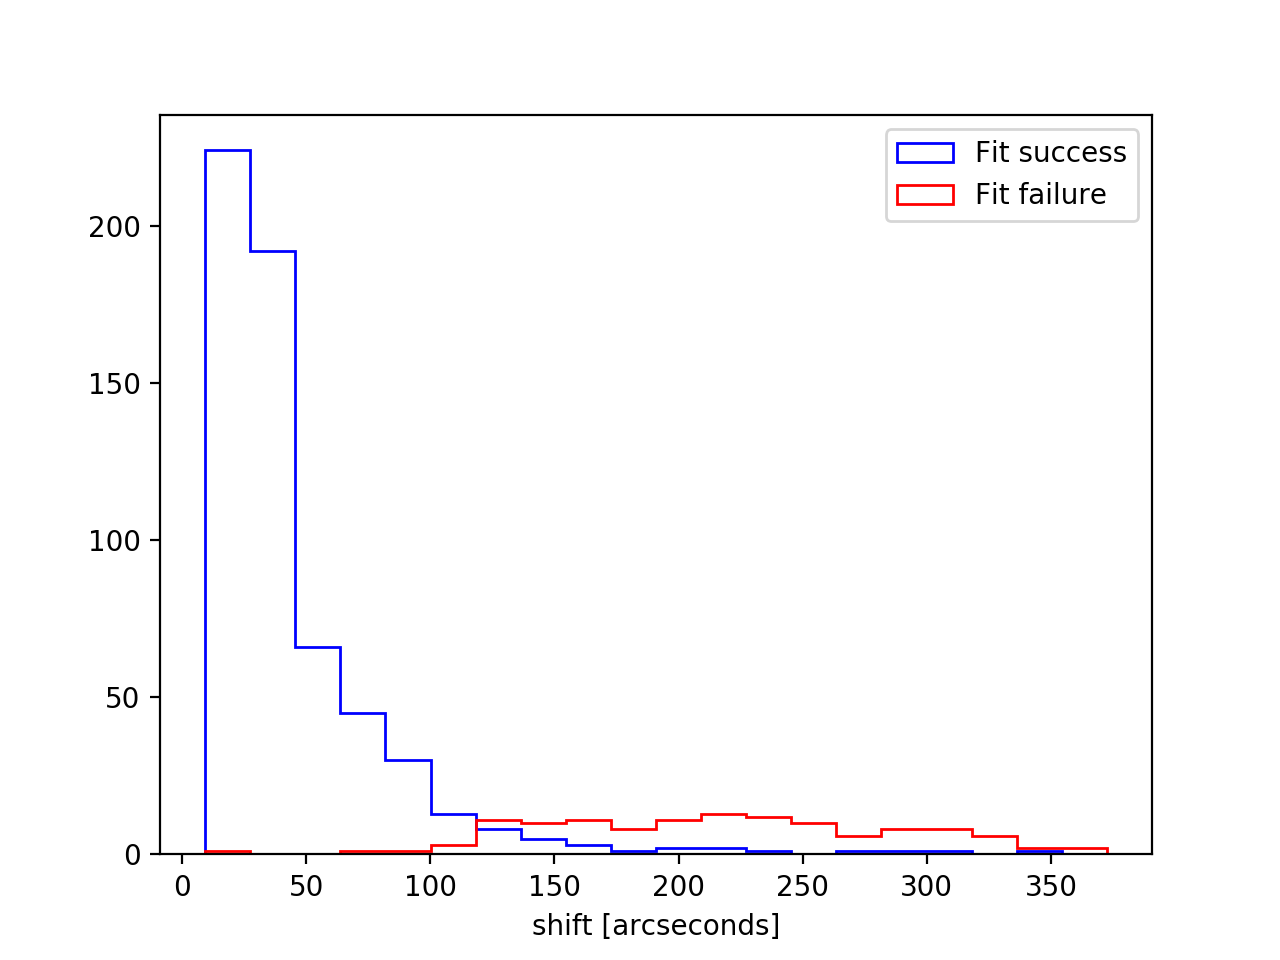

In [12]:
bins = np.linspace(allData["shiftTrue"].min(), allData["shiftTrue"].max(), 21)
plt.figure()
plt.hist(allData["shiftTrue"][allData["fitSuccess"]], histtype="step", color="b",
         bins=bins, label="Fit success")
plt.hist(allData["shiftTrue"][~allData["fitSuccess"]], histtype="step", color="r",
         bins=bins, label="Fit failure")
plt.xlabel("shift [arcseconds]")
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


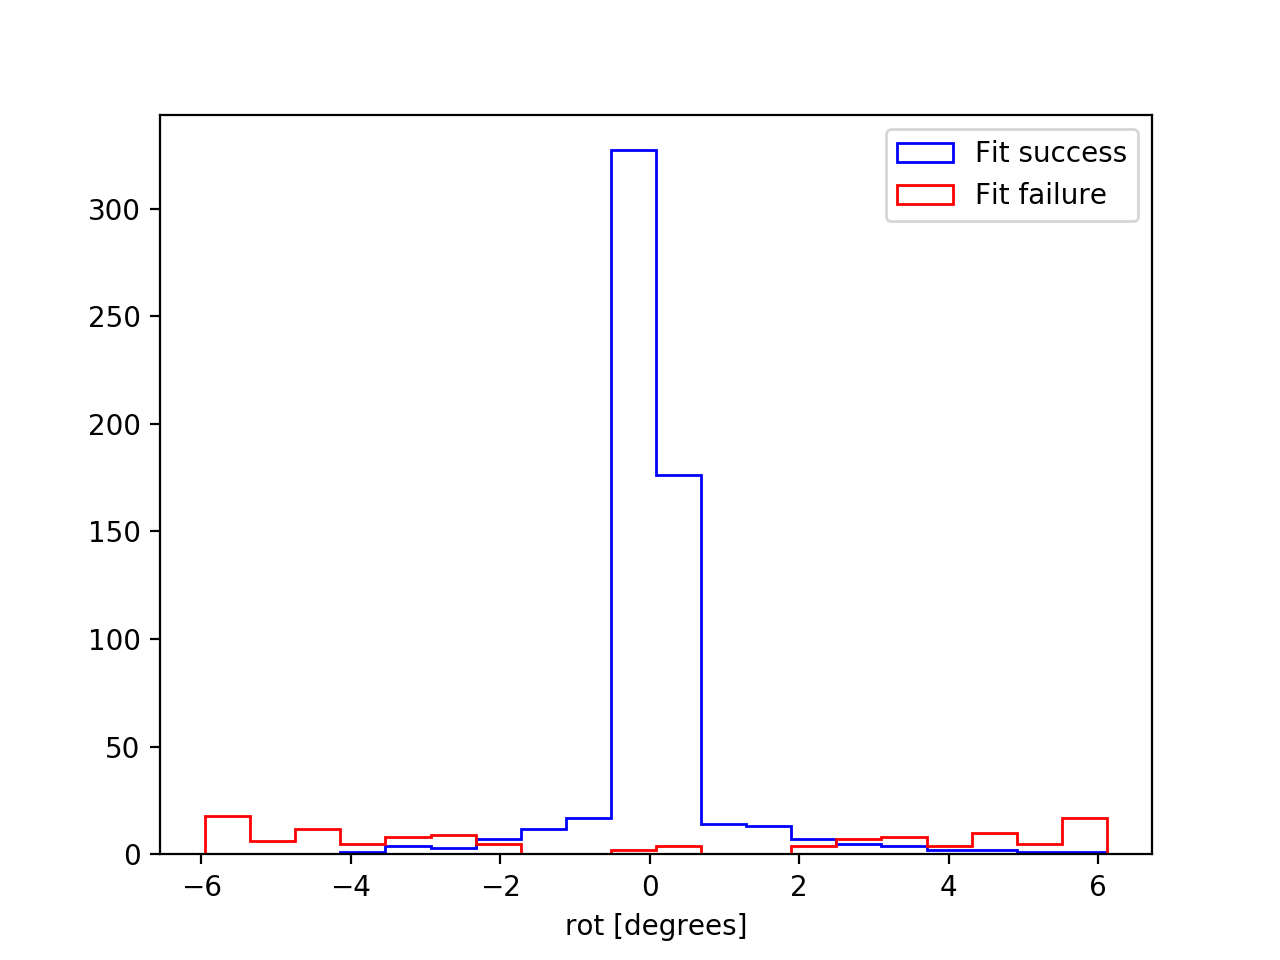

In [13]:
bins = np.linspace(allData["rotTrue"].min(), allData["rotTrue"].max(), 21)
plt.figure()
plt.hist(allData["rotTrue"][allData["fitSuccess"]], histtype="step", color="b",
         bins=bins, label="Fit success")
plt.hist(allData["rotTrue"][~allData["fitSuccess"]], histtype="step", color="r",
         bins=bins, label="Fit failure")
plt.xlabel("rot [degrees]")
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


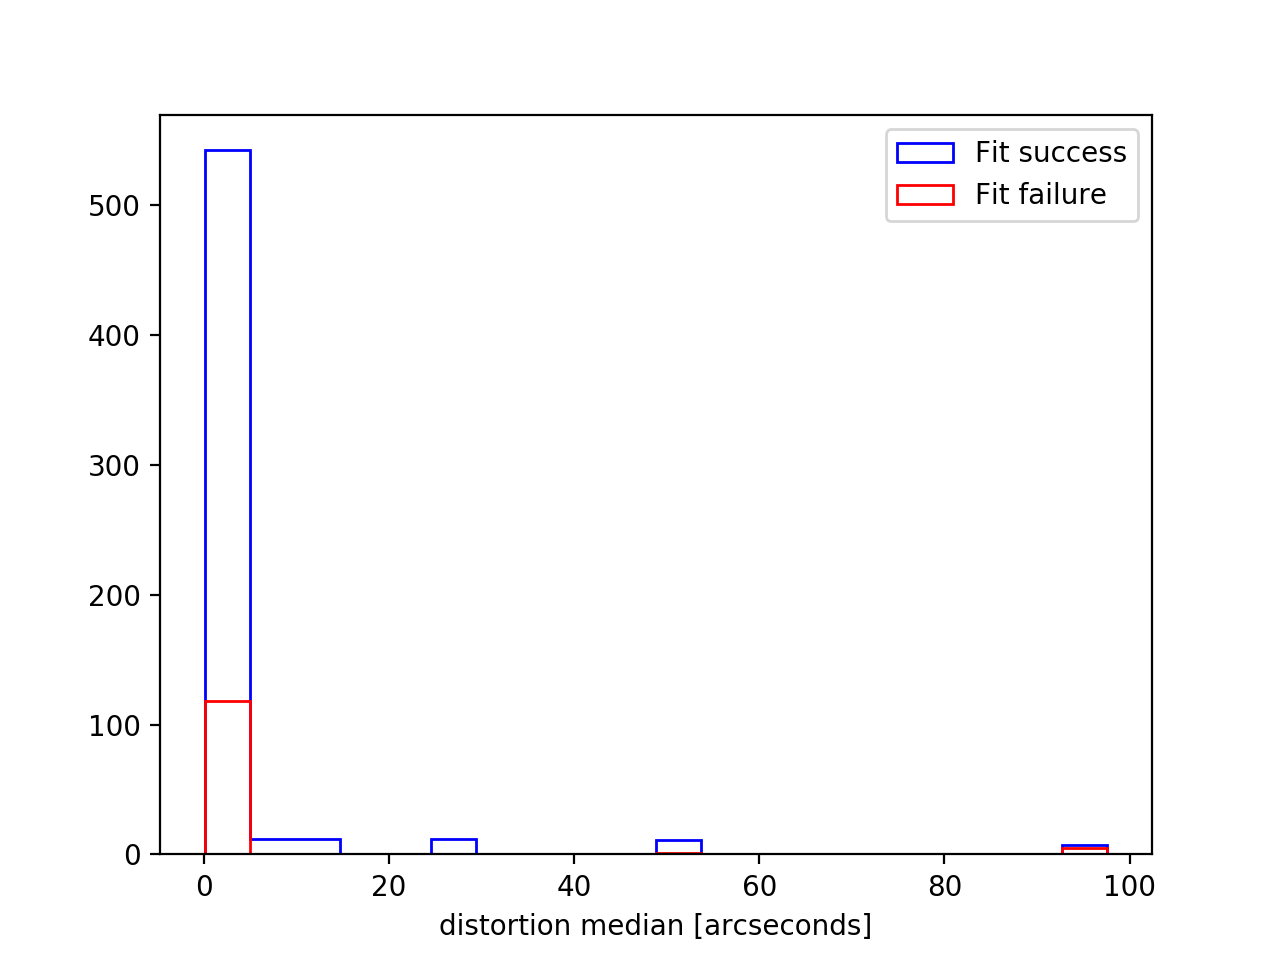

In [14]:
bins = np.linspace(allData["distMedian"].min(), allData["distMedian"].max(), 21)
plt.figure()
plt.hist(allData["distMedian"][allData["fitSuccess"]], histtype="step", color="b",
         bins=bins, label="Fit success")
plt.hist(allData["distMedian"][~allData["fitSuccess"]], histtype="step", color="r",
         bins=bins, label="Fit failure")
plt.xlabel("distortion median [arcseconds]")
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


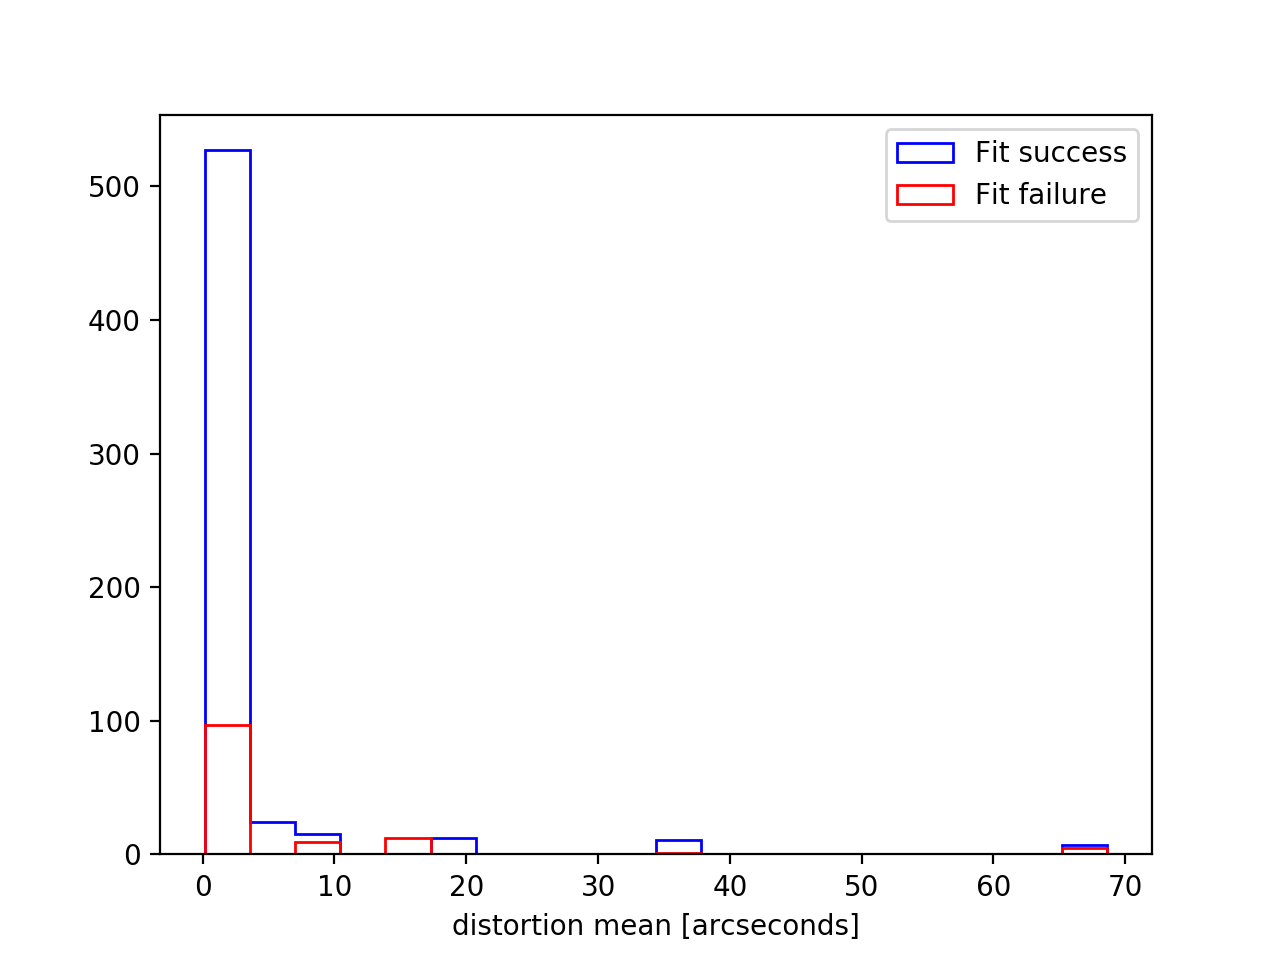

In [15]:
bins = np.linspace(allData["distMean"].min(), allData["distMean"].max(), 21)
plt.figure()
plt.hist(allData["distMean"][allData["fitSuccess"]], histtype="step", color="b",
         bins=bins, label="Fit success")
plt.hist(allData["distMean"][~allData["fitSuccess"]], histtype="step", color="r",
         bins=bins, label="Fit failure")
plt.xlabel("distortion mean [arcseconds]")
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


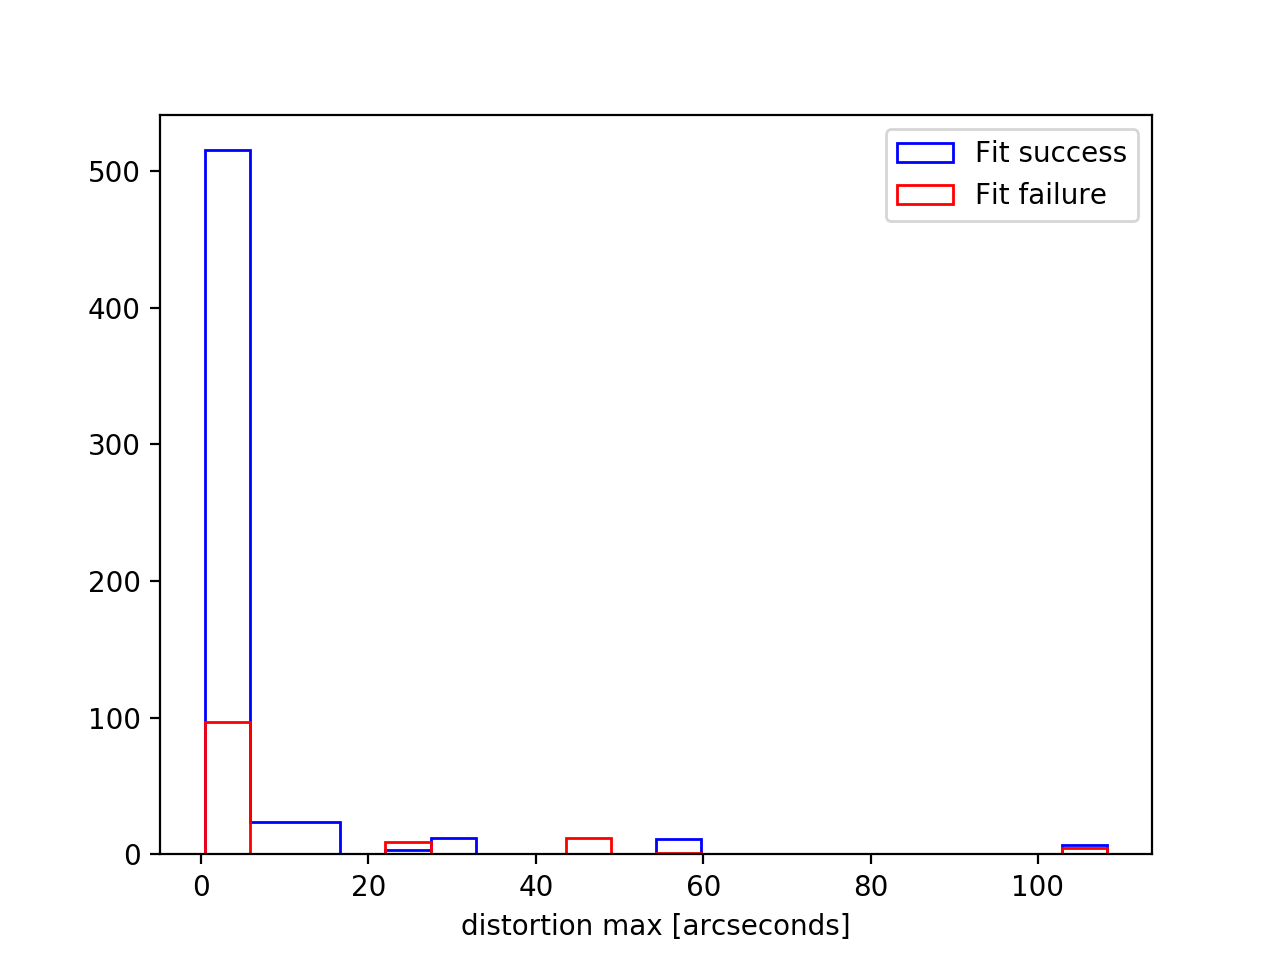

In [16]:
bins = np.linspace(allData["distMax"].min(), allData["distMax"].max(), 21)
plt.figure()
plt.hist(allData["distMax"][allData["fitSuccess"]], histtype="step", color="b",
         bins=bins, label="Fit success")
plt.hist(allData["distMax"][~allData["fitSuccess"]], histtype="step", color="r",
         bins=bins, label="Fit failure")
plt.xlabel("distortion max [arcseconds]")
plt.legend(loc=0)
plt.show()

Scatter Plots
==========

Below are plots of one of the injected wcs values against another. They show clear regions of sucess for the match/fit cycle. For instance, in the shfit/rotation plot, a clear turn over happens at ~100 arcseconds of shift (about the max allowed shift of 300 pixels in the pipeline config). The two red, failure dots in this plot are likely due to large due to large distortions.

The distortion vs shift plots show successes in match/fitting for the same rough shift amount with distortions of ~40 arcseconds succeeding.

Rot vs distortion shows a similar trend though the variables here are more indepedent. 

<IPython.core.display.Javascript object>


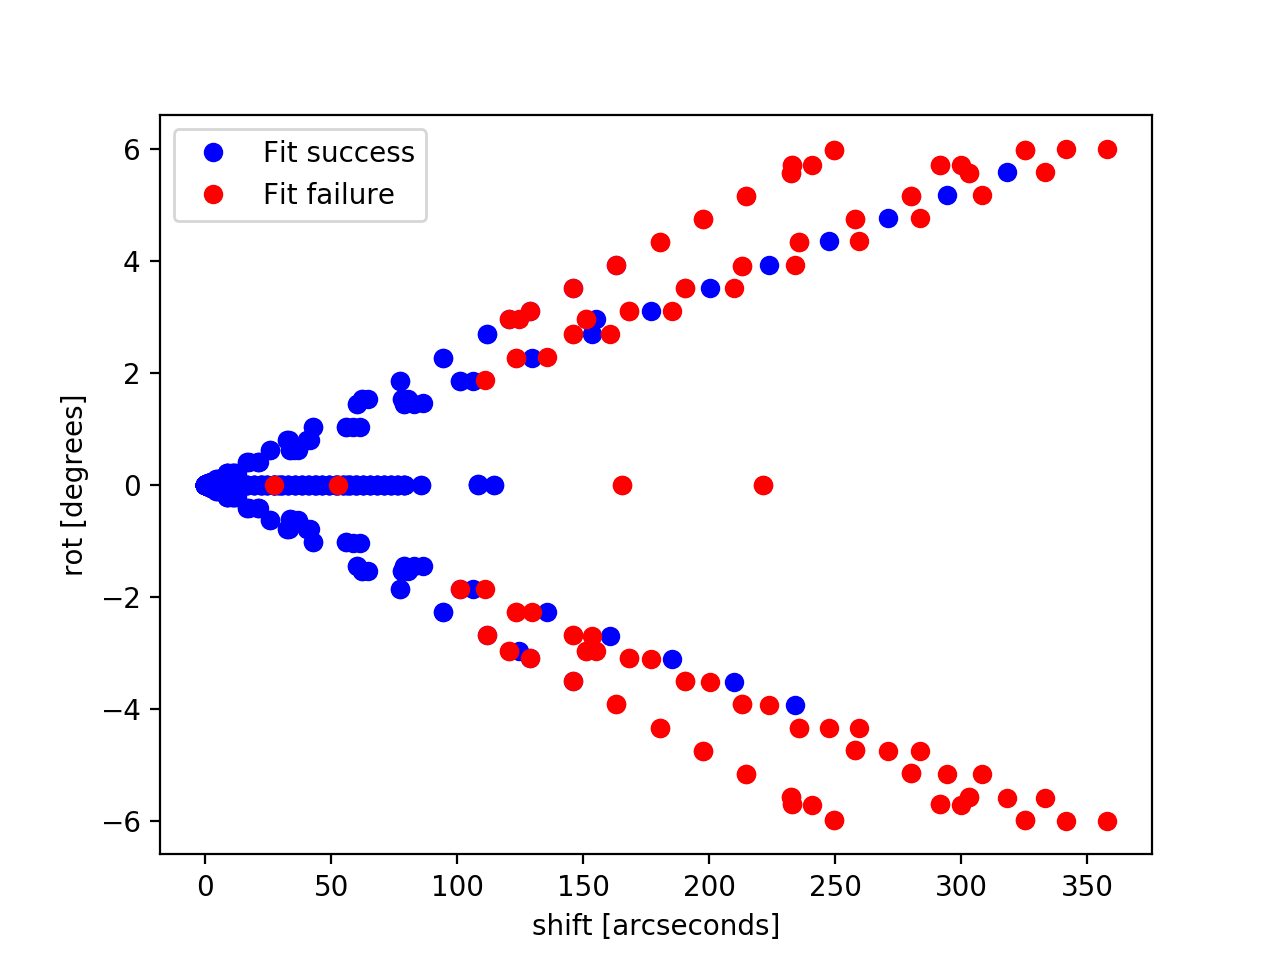

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y =

In [17]:
plt.figure()
plt.plot(allData["shiftTrue"][allData["fitSuccess"]],
         allData["rotTrue"][allData["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData["shiftTrue"][~allData["fitSuccess"]],
         allData["rotTrue"][~allData["fitSuccess"]],
         "ro", label="Fit failure")
plt.legend(loc=0)
plt.xlabel("shift [arcseconds]")
plt.ylabel("rot [degrees]")
plt.show()

<IPython.core.display.Javascript object>


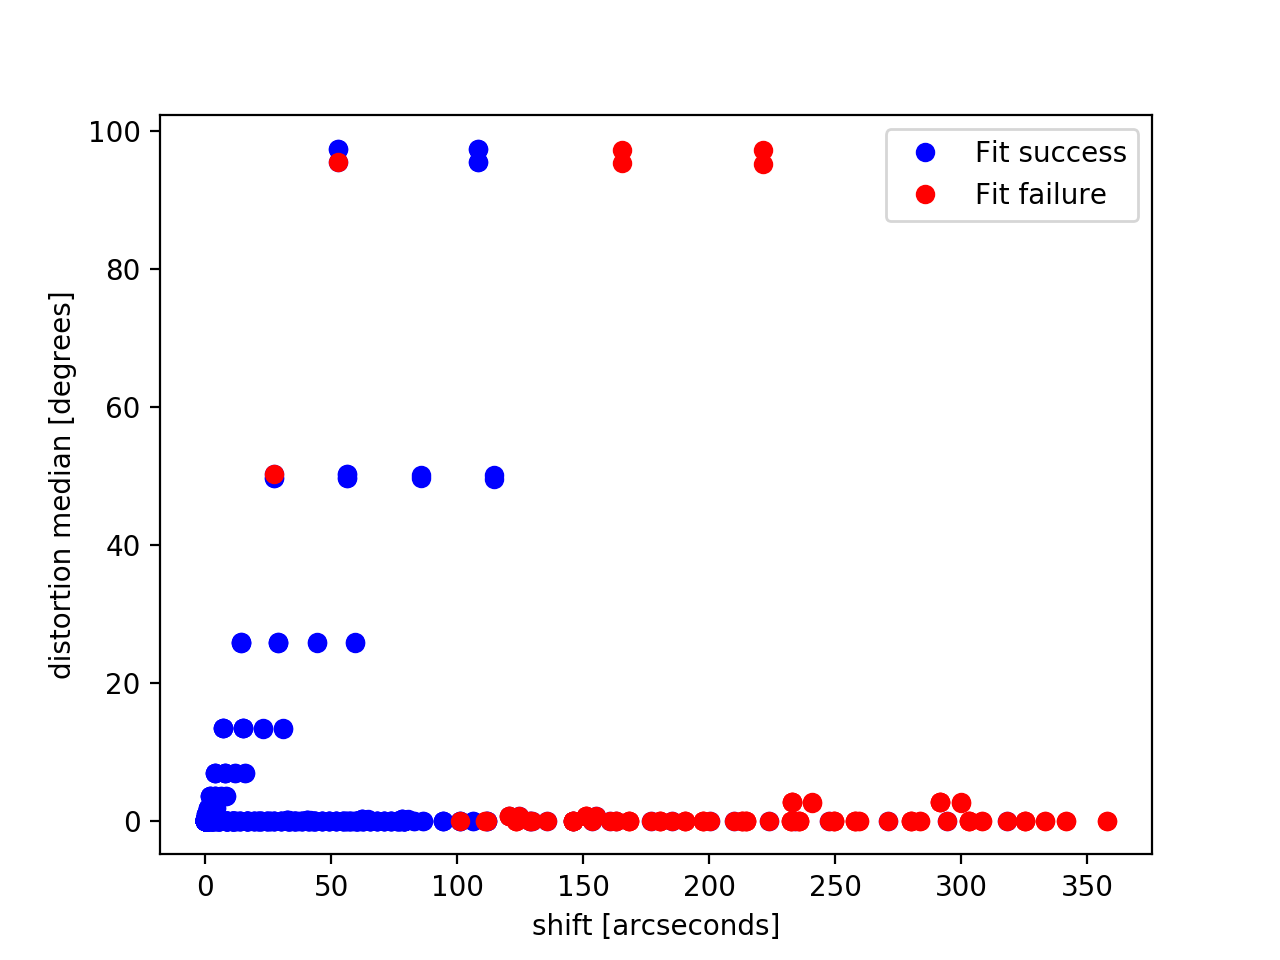

In [18]:
plt.figure()
plt.plot(allData["shiftTrue"][allData["fitSuccess"]],
         allData["distMedian"][allData["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData["shiftTrue"][~allData["fitSuccess"]],
         allData["distMedian"][~allData["fitSuccess"]],
         "ro", label="Fit failure")
plt.legend(loc=0)
plt.xlabel("shift [arcseconds]")
plt.ylabel("distortion median [degrees]")
plt.show()

<IPython.core.display.Javascript object>


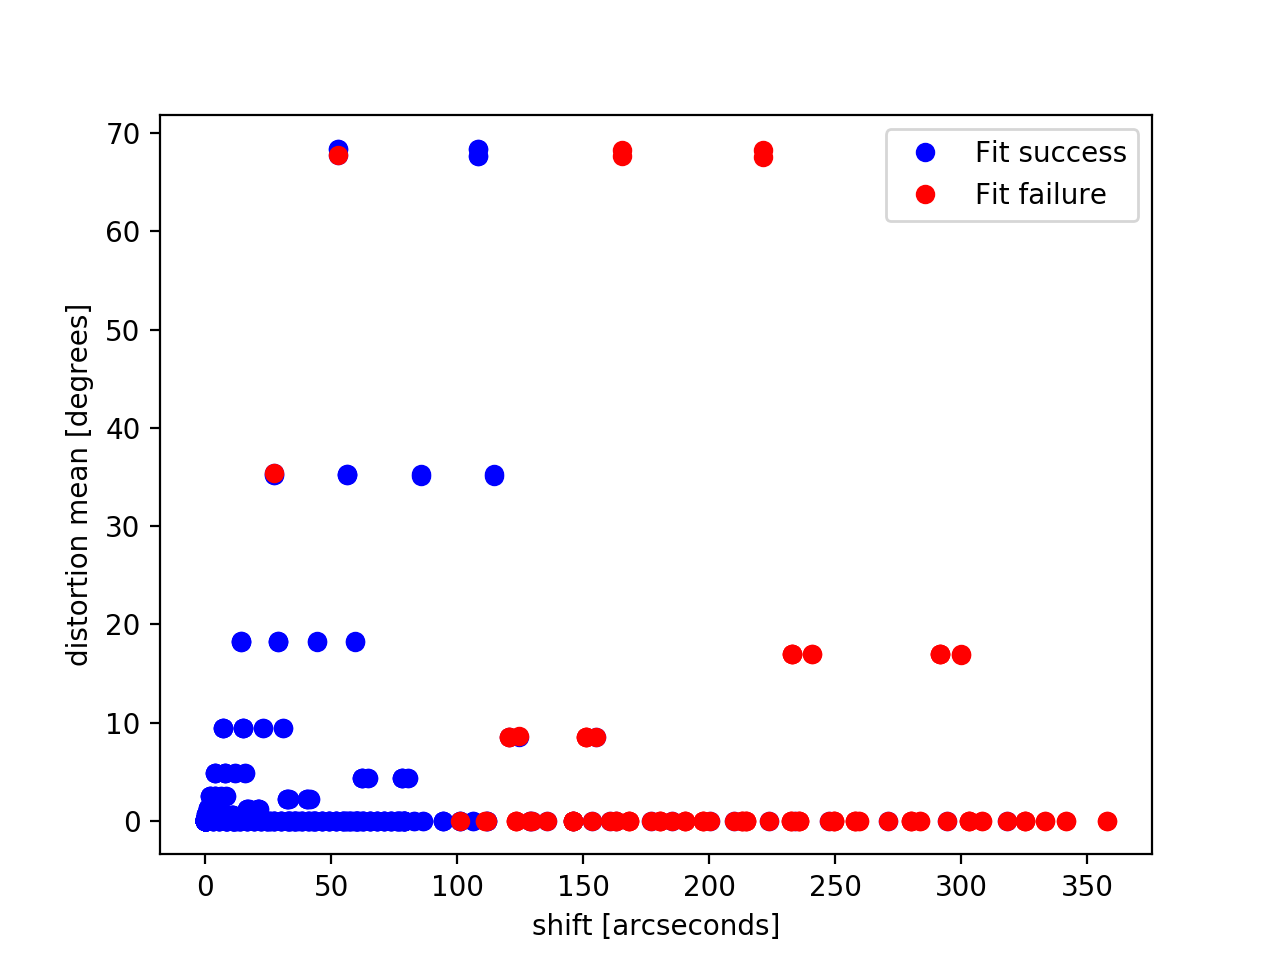

In [19]:
plt.figure()
plt.plot(allData["shiftTrue"][allData["fitSuccess"]],
         allData["distMean"][allData["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData["shiftTrue"][~allData["fitSuccess"]],
         allData["distMean"][~allData["fitSuccess"]],
         "ro", label="Fit failure")
plt.legend(loc=0)
plt.xlabel("shift [arcseconds]")
plt.ylabel("distortion mean [degrees]")
plt.show()

<IPython.core.display.Javascript object>


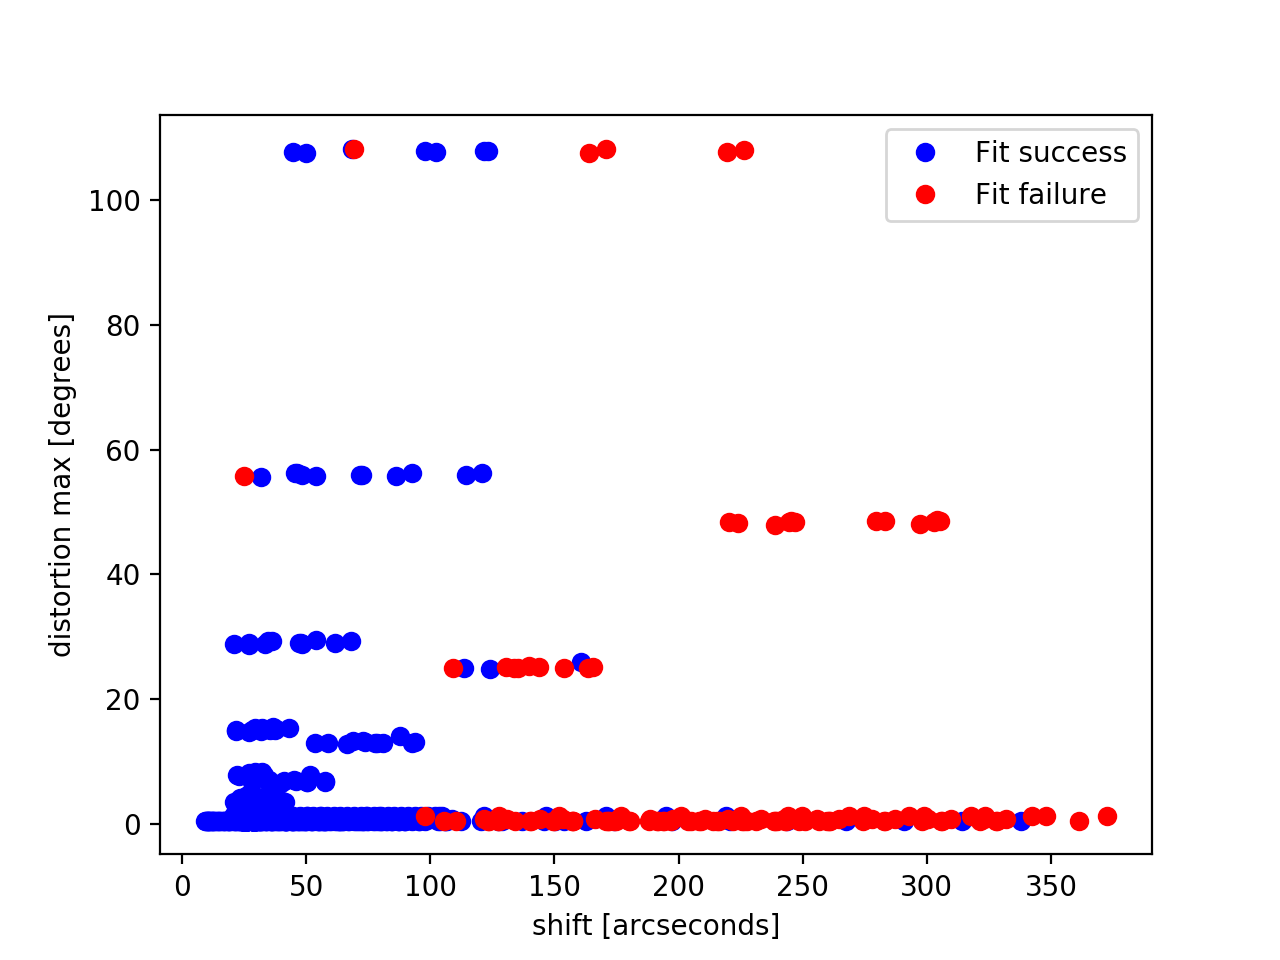

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y =

In [17]:
plt.figure()
plt.plot(allData["shiftTrue"][allData["fitSuccess"]],
         allData["distMax"][allData["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData["shiftTrue"][~allData["fitSuccess"]],
         allData["distMax"][~allData["fitSuccess"]],
         "ro", label="Fit failure")
plt.legend(loc=0)
plt.xlabel("shift [arcseconds]")
plt.ylabel("distortion max [degrees]")
plt.show()

<IPython.core.display.Javascript object>


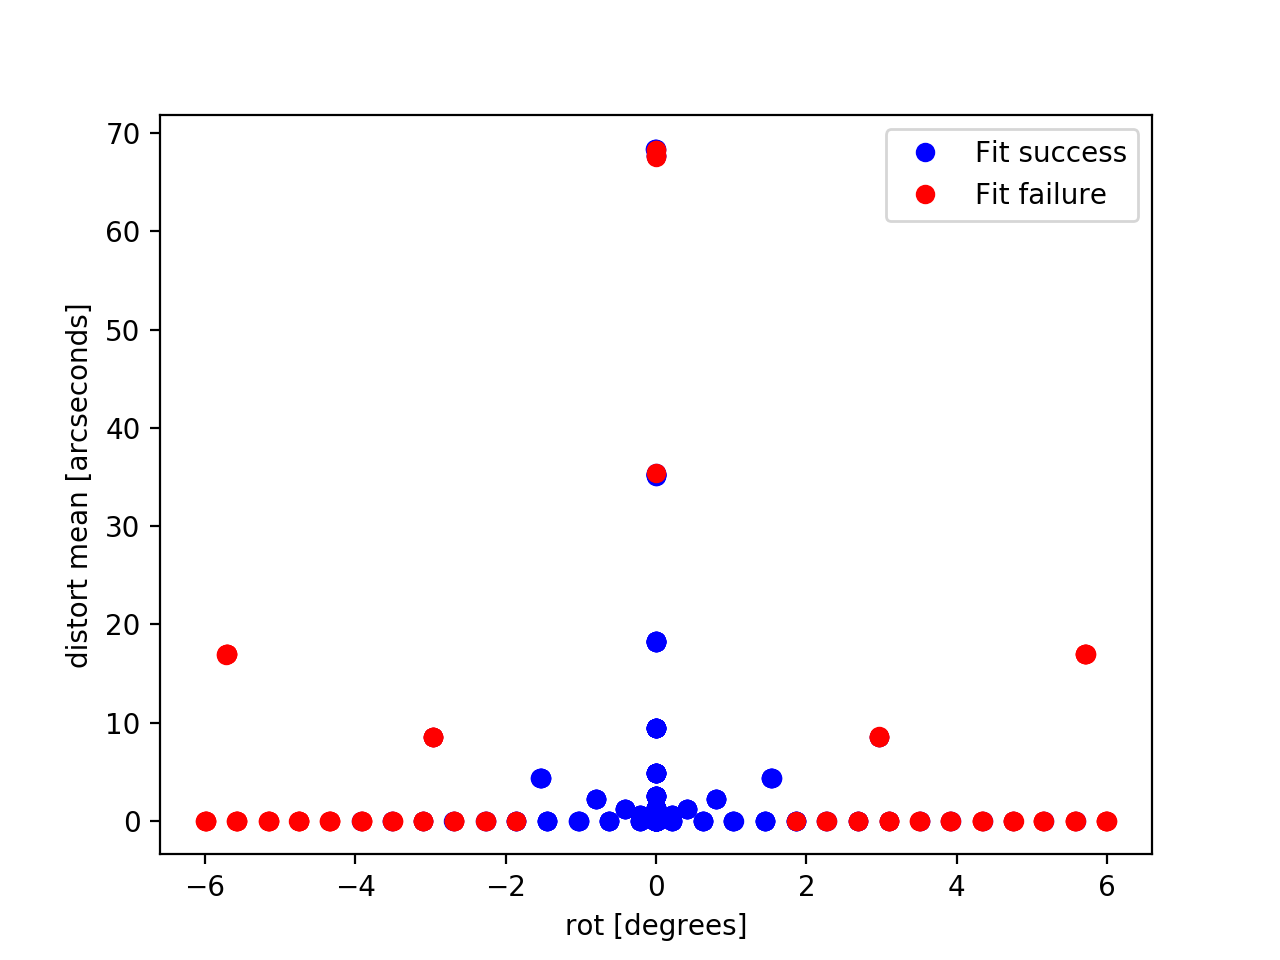

In [20]:
plt.figure()
plt.plot(allData["rotTrue"][allData["fitSuccess"]],
         allData["distMean"][allData["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData["rotTrue"][~allData["fitSuccess"]],
         allData["distMean"][~allData["fitSuccess"]],
         "ro", label="Fit failure")
plt.legend(loc=0)
plt.xlabel("rot [degrees]")
plt.ylabel("distort mean [arcseconds]")
plt.show()

<IPython.core.display.Javascript object>


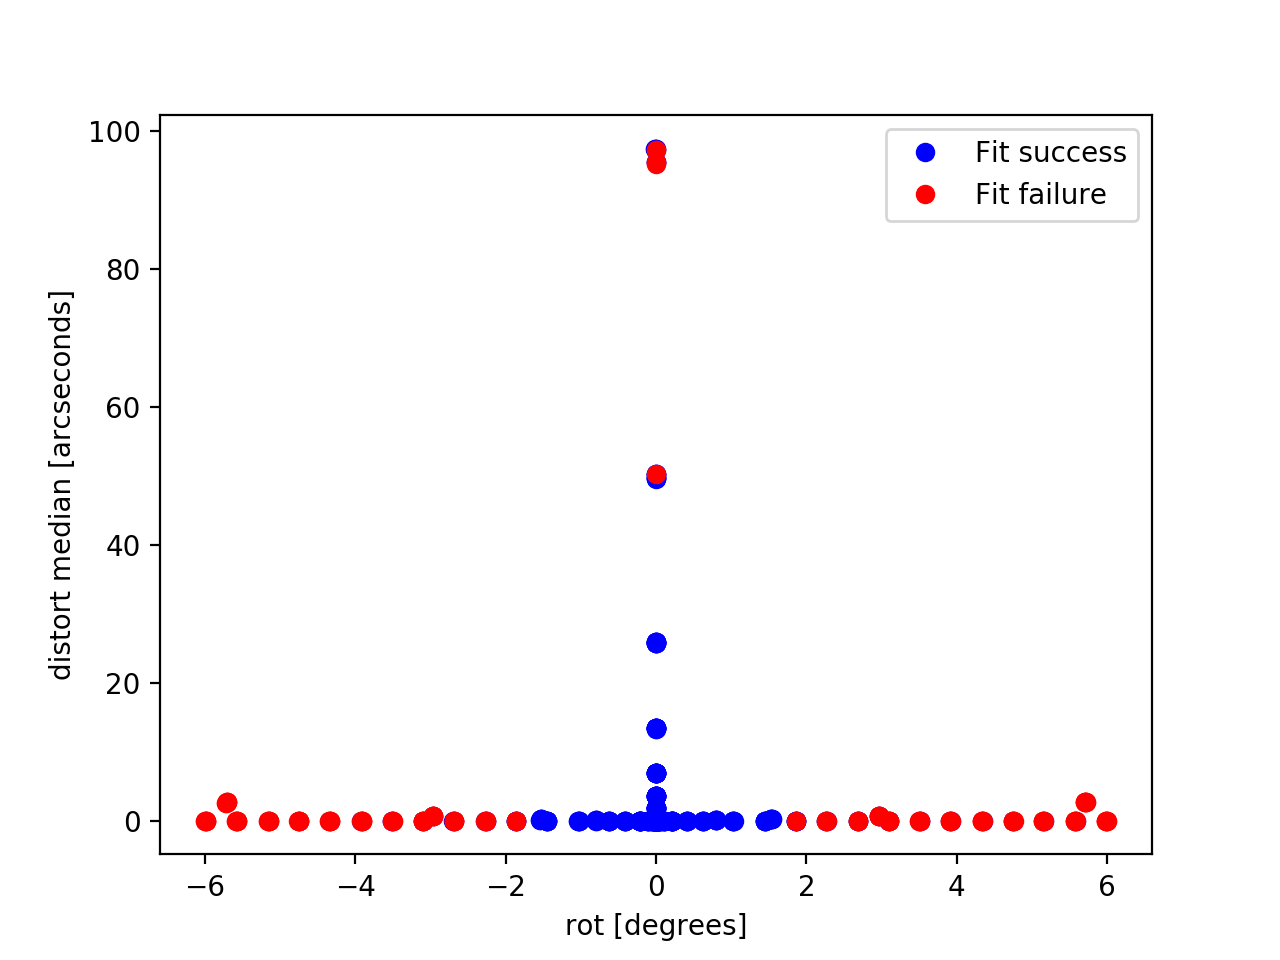

In [21]:
plt.figure()
plt.plot(allData["rotTrue"][allData["fitSuccess"]],
         allData["distMedian"][allData["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData["rotTrue"][~allData["fitSuccess"]],
         allData["distMedian"][~allData["fitSuccess"]],
         "ro", label="Fit failure")
plt.legend(loc=0)
plt.xlabel("rot [degrees]")
plt.ylabel("distort median [arcseconds]")
plt.show()

Vs AM1 like statistic
================

Here we plot how repeatable the data is after each tweak. The data are for only those were tweaked purposely tweaked in a given way (e.g. shift applied, rot applied, etc). The black line represents the design threshold for the AM1 metric from the Science Requirments (LPM-17). The AM1 here is approximate and is the comparison of distances between pairs of all PARENT sources between the untweaked calexp and the matched and fit tweaked data.

We can see that some of the data that were successfully matched and fit in the pipelines are infact poor fits, with shifts being good out to 80 arcseconds, rotations out to ~2 degrees, and distortions of ~20 arcseconds for this DECam Data.

<IPython.core.display.Javascript object>


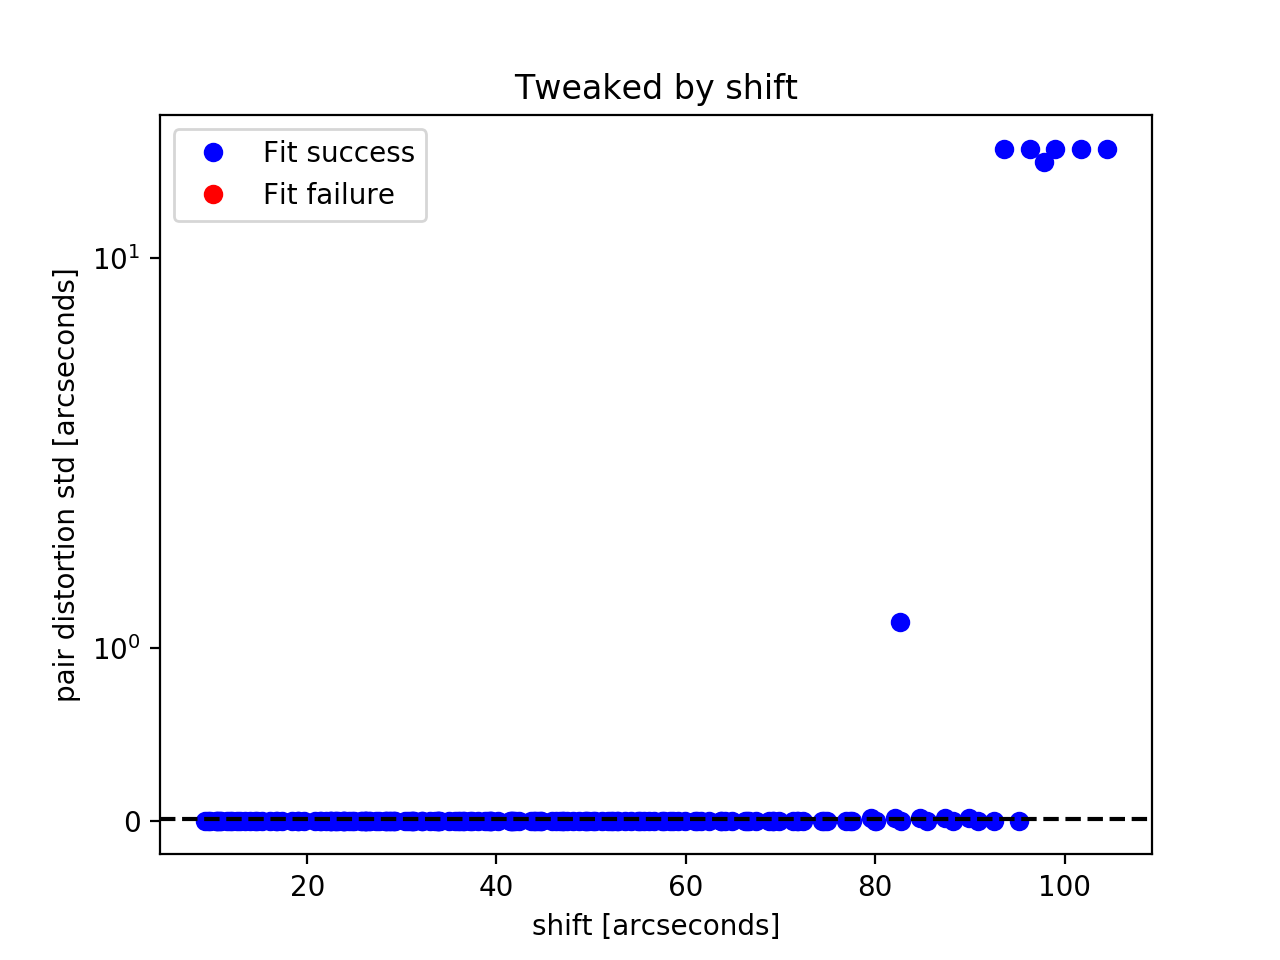

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y =

In [23]:
plt.figure()
mask = allData["shift"] > 0
plt.plot(allData[mask]["shiftTrue"][allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][allData[mask]["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData[mask]["shiftTrue"][~allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][~allData[mask]["fitSuccess"]],
         "ro", label="Fit failure")
plt.legend(loc=0)
plt.xlabel("shift [arcseconds]")
plt.ylabel("pair distortion std [arcseconds]")
plt.axhline(10**-2, color='k', ls='--')
plt.yscale("symlog", linthresh=10**-3)
# plt.ylim(0, 40 * 10**-3)
plt.title("Tweaked by shift")
plt.show()

<IPython.core.display.Javascript object>


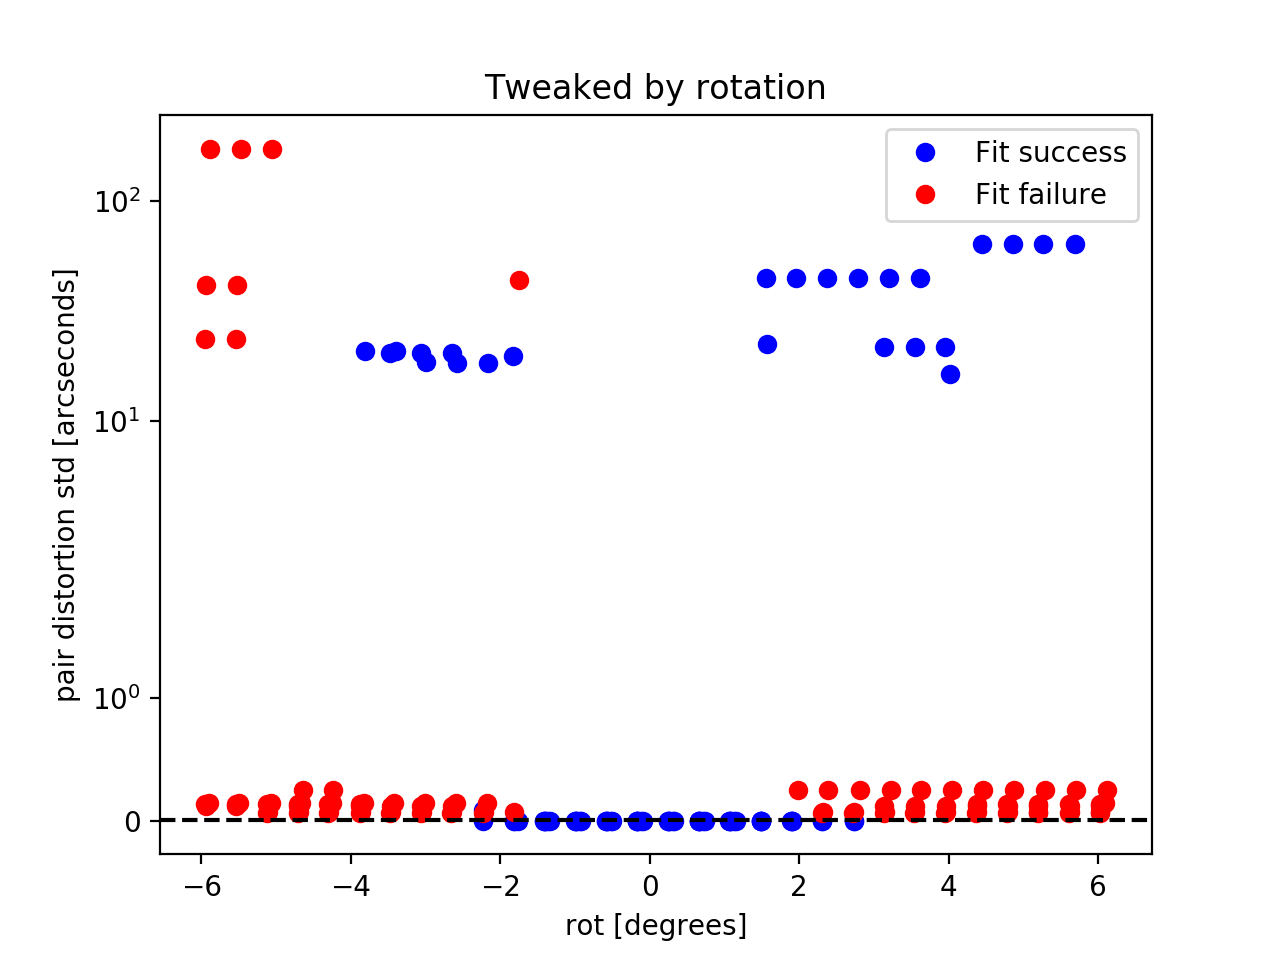

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y =

In [24]:
plt.figure()
mask = allData["rot"] != 0
plt.plot(allData[mask]["rotTrue"][allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][allData[mask]["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData[mask]["rotTrue"][~allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][~allData[mask]["fitSuccess"]],
         "ro", label="Fit failure")
plt.legend(loc=0)
plt.xlabel("rot [degrees]")
plt.ylabel("pair distortion std [arcseconds]")
plt.axhline(10**-2, color='k', ls='--')
plt.yscale("symlog", linthresh=10**-3)
plt.title("Tweaked by rotation")
# plt.ylim(0, 40 * 10**-3)
plt.show()

<IPython.core.display.Javascript object>


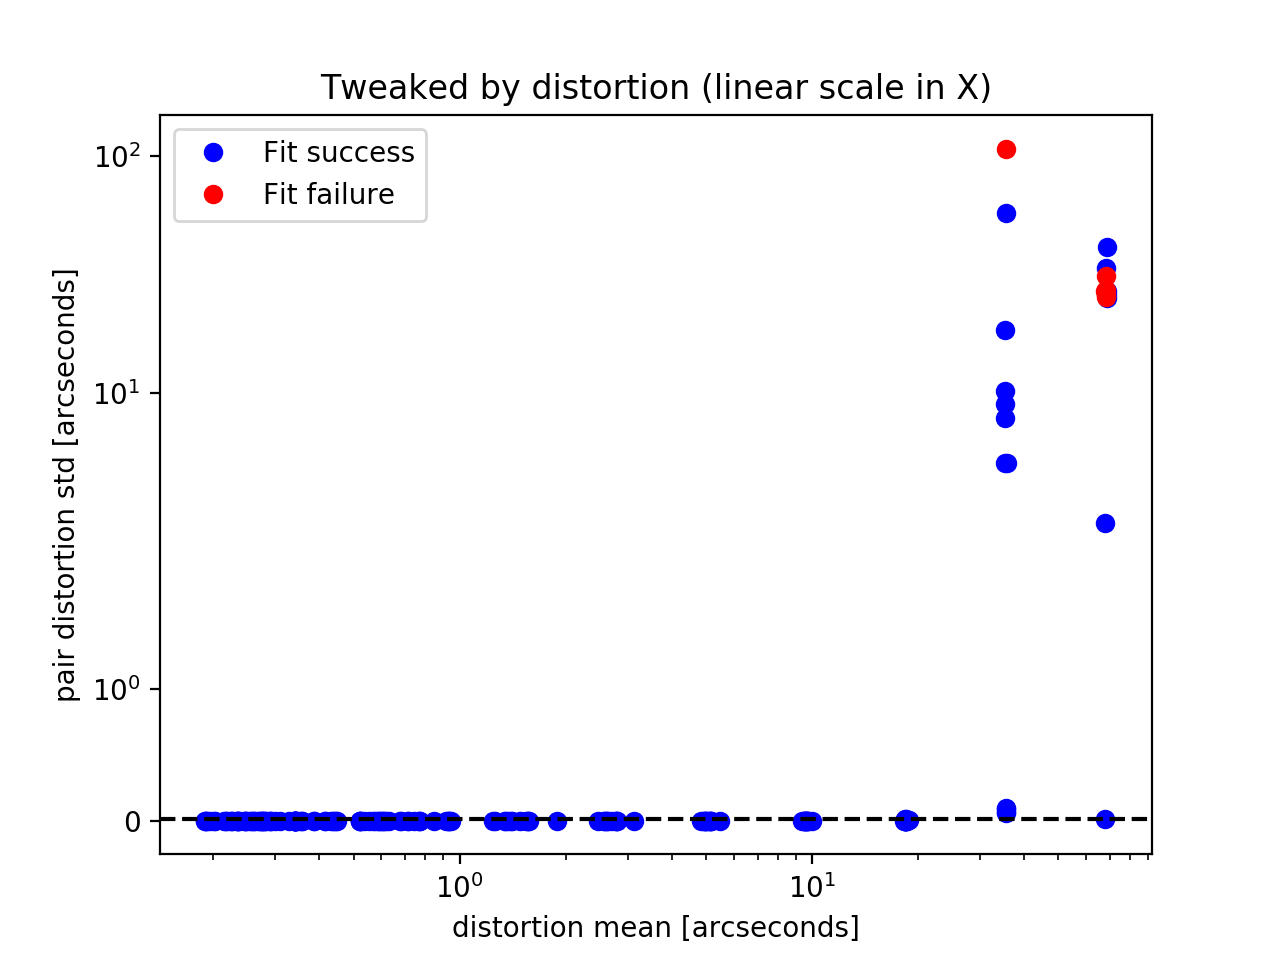

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y =

In [28]:
plt.figure()
mask = np.logical_or(allData["affineXScale"] > 1.0,
                     allData["affineXScale"] < 1.0)
plt.plot(allData[mask]["distMean"][allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][allData[mask]["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData[mask]["distMean"][~allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][~allData[mask]["fitSuccess"]],
         "ro", label="Fit failure")
plt.semilogx()
plt.yscale("symlog", linthresh=10**-3)
plt.axhline(10**-2, color='k', ls='--')
plt.legend(loc=0)
plt.xlabel("distortion mean [arcseconds]")
plt.ylabel("pair distortion std [arcseconds]")
plt.title("Tweaked by distortion (linear scale in X)")
# plt.ylim(0, 40 * 10**-3)
plt.show()

<IPython.core.display.Javascript object>


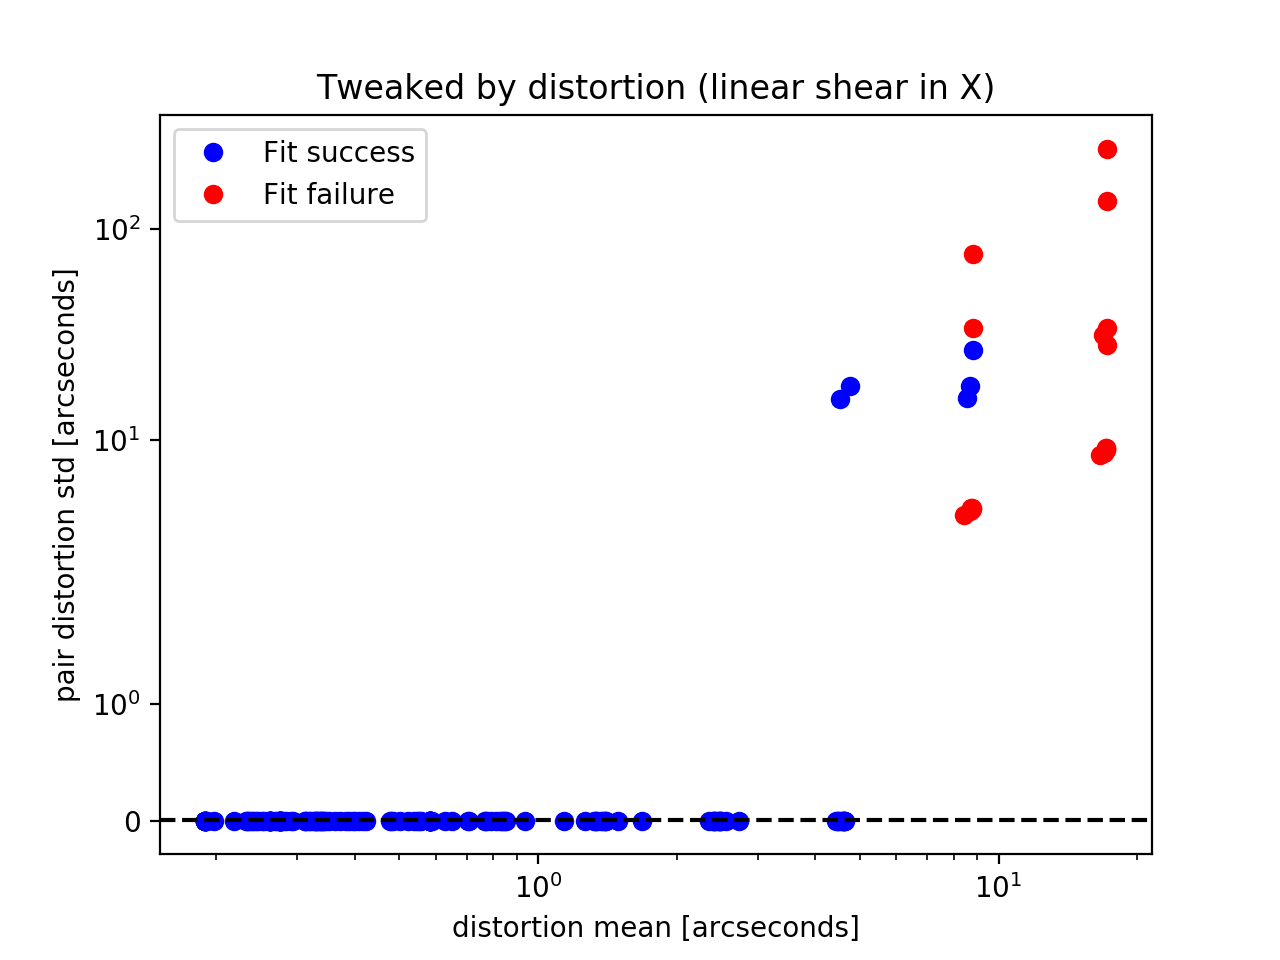

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y =

In [30]:
plt.figure()
mask = np.logical_or(allData["affineXShear"] > 0,
                     allData["affineXShear"] < 0)
plt.plot(allData[mask]["distMean"][allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][allData[mask]["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData[mask]["distMean"][~allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][~allData[mask]["fitSuccess"]],
         "ro", label="Fit failure")
plt.semilogx()
plt.axhline(10**-2, color='k', ls='--')
plt.yscale("symlog", linthresh=10**-3)
plt.legend(loc=0)
plt.xlabel("distortion mean [arcseconds]")
plt.title("Tweaked by distortion (linear shear in X)")
plt.ylabel("pair distortion std [arcseconds]")
# plt.ylim(0, 40 * 10**-3)
plt.show()

<IPython.core.display.Javascript object>


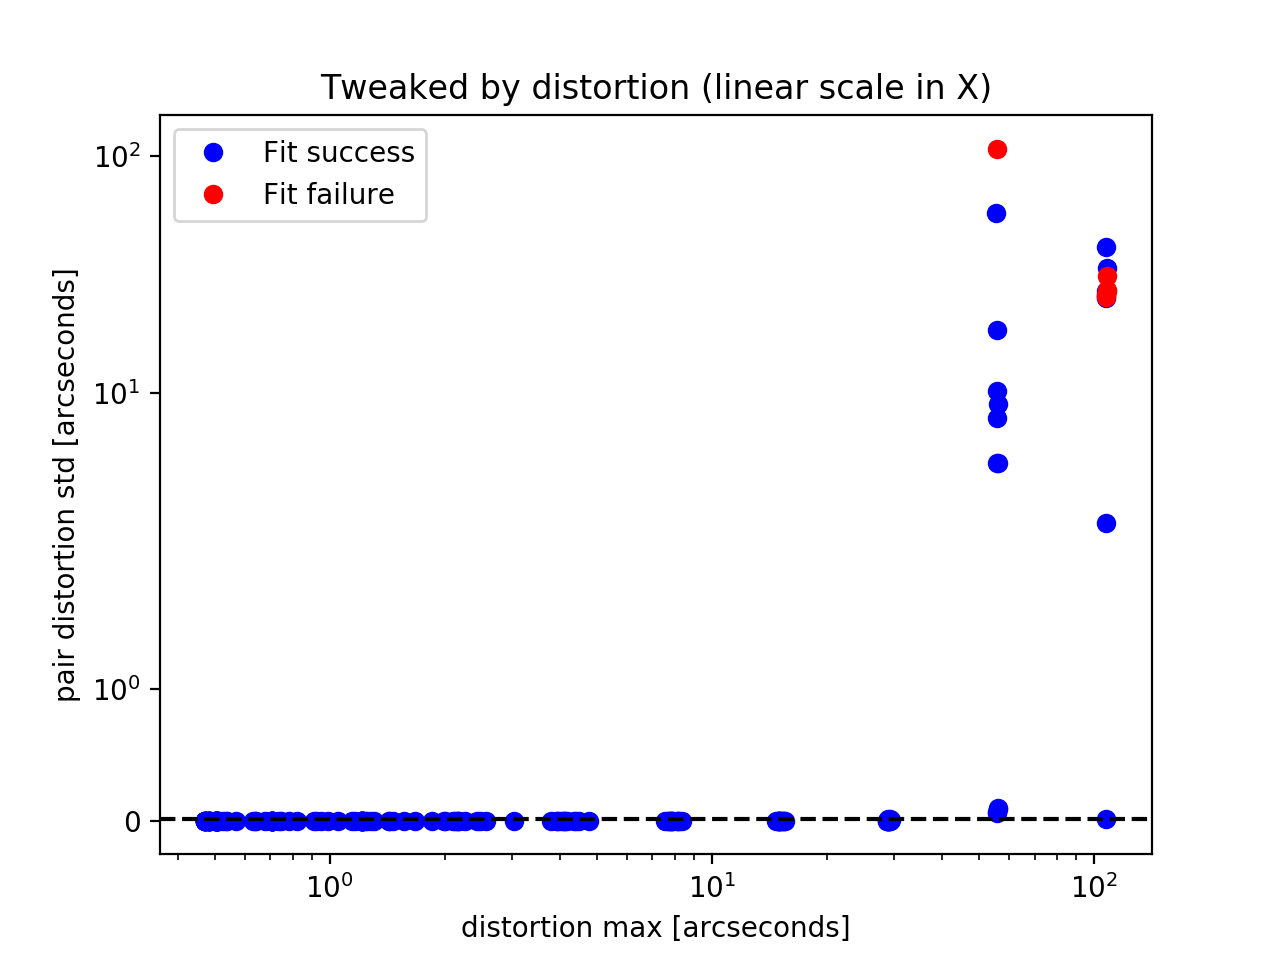

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y =

In [32]:
plt.figure()
mask = np.logical_or(allData["affineXScale"] > 1,
                     allData["affineXScale"] < 1)
plt.plot(allData[mask]["distMax"][allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][allData[mask]["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData[mask]["distMax"][~allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][~allData[mask]["fitSuccess"]],
         "ro", label="Fit failure")
plt.semilogx()
plt.axhline(10**-2, color='k', ls='--')
plt.yscale("symlog", linthresh=10**-3)
plt.legend(loc=0)
plt.xlabel("distortion max [arcseconds]")
plt.ylabel("pair distortion std [arcseconds]")
plt.title("Tweaked by distortion (linear scale in X)")
# plt.ylim(0, 40 * 10**-3)
plt.show()

<IPython.core.display.Javascript object>


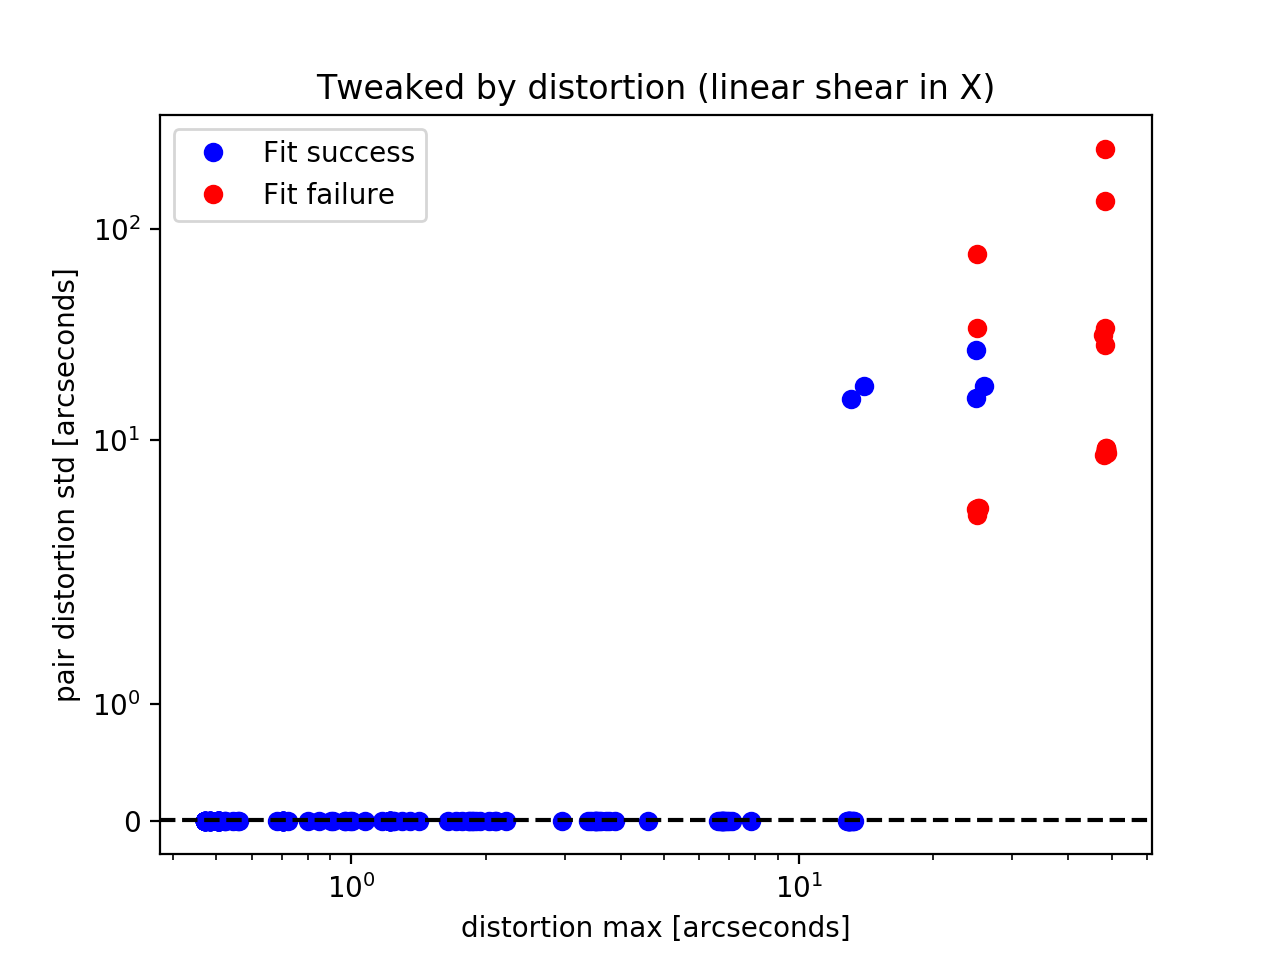

/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/software/lsstsw/stack_20200922/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y =

In [33]:
plt.figure()
mask = np.logical_or(allData["affineXShear"] > 0,
                     allData["affineXShear"] < 0)
plt.plot(allData[mask]["distMax"][allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][allData[mask]["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(allData[mask]["distMax"][~allData[mask]["fitSuccess"]],
         allData[mask]["stdDelta"][~allData[mask]["fitSuccess"]],
         "ro", label="Fit failure")
plt.semilogx()
plt.axhline(10**-2, color='k', ls='--')
plt.yscale("symlog", linthresh=10**-3)
plt.legend(loc=0)
plt.xlabel("distortion max [arcseconds]")
plt.ylabel("pair distortion std [arcseconds]")
plt.title("Tweaked by distortion (linear shear in X)")
# plt.ylim(0, 40 * 10**-3)
plt.show()